初期コードを読み込み

In [1]:
!nvidia-smi

Wed Jan  3 01:54:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

base_path = '/content/drive/MyDrive/x_ray_chest/results/ssd'
ver = 'v1'

# 新しいフォルダを生成
weight_folder = 'weight'
train_folder = 'train'
test_folder = 'test'
test_img_folder = 'images'

weight_folder_path = os.path.join(base_path, ver, weight_folder)
train_folder_path = os.path.join(base_path, ver, train_folder)
test_folder_path = os.path.join(base_path, ver, test_folder)
test_img_path = os.path.join(base_path, ver, test_folder, test_img_folder)

In [4]:
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
BBox_List_path = '/content/drive/MyDrive/x_ray_chest/BBox_List_2017.csv'
Data_Entry_path = '/content/drive/MyDrive/x_ray_chest/Data_Entry_2017_v2020.csv'

BBox_List_df = pd.read_csv(BBox_List_path)
Data_Entry_df = pd.read_csv(Data_Entry_path)

In [6]:
print(BBox_List_df[0:5])

        Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0   79.186441         NaN         NaN         NaN  
1  313.491525         NaN         NaN         NaN  
2  216.949153         NaN         NaN         NaN  
3   55.322034         NaN         NaN         NaN  
4   78.101695         NaN         NaN         NaN  


In [7]:
print(Data_Entry_df[0:5])

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                       

In [8]:
print(len(BBox_List_df))
print(len(BBox_List_df.iloc[:,0].unique()))
print(len(Data_Entry_df))
print(len(Data_Entry_df.iloc[:,0].unique()))

984
880
112120
112120


In [9]:
data_list = BBox_List_df.merge(Data_Entry_df, on='Image Index', how='inner')
data_list = data_list.set_axis(['img_name', 'label', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'nan1', 'nan2', 'nan3', 'labels', 'follow_up', 'id', 'age', 'gender', 'view_posi', 'ori_img_w', 'ori_img_h', 'pixel_mm_x', 'pixel_mm_y'], axis=1)
data_list = data_list.drop(['nan1', 'nan2', 'nan3', 'labels', 'follow_up', 'id', 'age', 'gender', 'view_posi', 'pixel_mm_x', 'pixel_mm_y'], axis=1)

print(data_list[0:5])

           img_name        label      bbox_x      bbox_y      bbox_w  \
0  00013118_008.png  Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png  Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png  Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png  Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png  Atelectasis  660.067797  569.780787  200.677966   

       bbox_h  ori_img_w  ori_img_h  
0   79.186441       2992       2991  
1  313.491525       3056       2544  
2  216.949153       3056       2544  
3   55.322034       2500       2048  
4   78.101695       2500       2048  


In [10]:
file_name_list = [i for i in data_list['img_name'].unique()]
print(len(file_name_list))

880


In [11]:
import torch
from torch.utils.data import Dataset
import sys
import h5py
import matplotlib.pyplot as plt
import cv2

In [12]:
import torchvision
from torchvision import datasets
from torchvision import transforms

pytorchモデルの編集を行う場合はsysでパスを通してimport

In [13]:
# 画像データをimagesに格納

file_path = '/content/drive/MyDrive/x_ray_chest/file.hdf5'

images = []

with h5py.File(file_path, "r") as f:
    group = f["/images"]

    for i in range(len(file_name_list)):
        file_name = file_name_list[i]

        if file_name in group:
            dataset = group[file_name]
            img_data = np.array(dataset)
            img_tensor = transforms.Compose([transforms.ToTensor()])(img_data)
            images.append(img_tensor)

In [14]:
boxes = []

for file_name in file_name_list:
    box = []
    row = data_list['img_name'] == file_name
    data = data_list[row]

    for i in range(len(data)):
        lx = data['bbox_x'].iloc[i]
        ly = data['bbox_y'].iloc[i]
        rx = data['bbox_x'].iloc[i] + data['bbox_w'].iloc[i]
        ry = data['bbox_y'].iloc[i] + data['bbox_h'].iloc[i]
        bbox = [lx, ly, rx, ry]
        box.append(bbox)

    box_tensor = torch.tensor(box, dtype = torch.float)

    boxes.append(box_tensor)

In [15]:
labels = []
label_kind = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

for file_name in file_name_list:
    label = []
    row = data_list['img_name'] == file_name
    data = data_list[row]

    for i in range(len(data)):
        label_name = data['label'].iloc[i]
        label_index = label_kind.index(label_name)
        label.append(label_index)

    label_tensor = torch.tensor(label, dtype = torch.int64)

    labels.append(label_tensor)

In [16]:
print(len(images))
print(len(boxes))
print(len(labels))

880
880
880


In [17]:
dataset = []
for i in range(len(images)):
    data = (images[i], {'boxes':boxes[i], 'labels':labels[i]}, file_name_list[i])
    dataset.append(data)

In [18]:
train, val, test = torch.utils.data.random_split(dataset=dataset, lengths=[736, 72, 72], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train, batch_size = 1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle=False)

In [19]:
import torch
import torchvision

label_kind = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
num_classes = len(label_kind) + 1

model = torchvision.models.detection.ssd300_vgg16(weights = None, num_classes=num_classes)

model

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

特定のweightを読み込み、結果を表示

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

model_path = '/content/drive/MyDrive/x_ray_chest/results/ssd/v1/weight/weight_0112.pt'
model.load_state_dict(torch.load(model_path))

test_results = []

model.eval()
with torch.no_grad():

    for batch in test_loader:
        image, target, name = batch

        image = image.to(device)

        predictions = model(image)

        #print(predictions)
        image = image.cpu()
        truth_boxes = target['boxes'][0].cpu()
        truth_labels = target['labels'][0].cpu()

        predict_boxes = predictions[0]["boxes"].cpu()
        predict_labels = predictions[0]["labels"].cpu()
        predict_scores = predictions[0]["scores"].cpu()


        dict_info = {'image':image, 'truth_boxes':truth_boxes, 'truth_labels':truth_labels, 'file_name':name,
                     'predict_boxes':predict_boxes, 'predict_labels':predict_labels, 'scores':predict_scores}

        test_results.append(dict_info)


print(test_results[66])



{'image': tensor([[[[0.0078, 0.0118, 0.0118,  ..., 0.0235, 0.0275, 0.0118],
          [0.0157, 0.0275, 0.0275,  ..., 0.0471, 0.0549, 0.0275],
          [0.0157, 0.0275, 0.0275,  ..., 0.0471, 0.0471, 0.0314],
          ...,
          [0.0902, 0.1882, 0.2118,  ..., 0.0549, 0.0667, 0.0353],
          [0.0902, 0.2000, 0.2275,  ..., 0.0588, 0.0706, 0.0353],
          [0.0431, 0.0980, 0.1020,  ..., 0.0275, 0.0314, 0.0157]],

         [[0.0078, 0.0118, 0.0118,  ..., 0.0235, 0.0275, 0.0118],
          [0.0157, 0.0275, 0.0275,  ..., 0.0471, 0.0549, 0.0275],
          [0.0157, 0.0275, 0.0275,  ..., 0.0471, 0.0471, 0.0314],
          ...,
          [0.0902, 0.1882, 0.2118,  ..., 0.0549, 0.0667, 0.0353],
          [0.0902, 0.2000, 0.2275,  ..., 0.0588, 0.0706, 0.0353],
          [0.0431, 0.0980, 0.1020,  ..., 0.0275, 0.0314, 0.0157]],

         [[0.0078, 0.0118, 0.0118,  ..., 0.0235, 0.0275, 0.0118],
          [0.0157, 0.0275, 0.0275,  ..., 0.0471, 0.0549, 0.0275],
          [0.0157, 0.0275, 0.027

In [21]:
import random

def rand_num(start_num, fin_num, rand_num):
  ns = []
  while len(ns) < rand_num:
    n = random.randint(start_num, fin_num)
    if not n in ns:
      ns.append(n)
  return ns

def images_show(row_num, col_num):

    random.seed(42)
    num = rand_num(0, len(test_results)-1, row_num * col_num)

    print(num)

    fig, axes = plt.subplots(nrows=row_num, ncols=col_num, figsize=(12, 20), subplot_kw=({'xticks':(), 'yticks':()}))

    for i, ax in enumerate(axes.flat):

        j = num[i]
        test_results_dict = test_results[j]

        #元画像の設定
        img = (test_results_dict['image'][0] * 255).to(torch.uint8)
        img_ori = np.transpose(img.cpu().numpy(), (1, 2, 0))
        img_ori = cv2.cvtColor(img_ori, cv2.COLOR_RGB2BGR)

        #正解labelごとにループ
        for i in range(len(test_results_dict['truth_labels'])):

            #正解bbox,labelの色を指定
            t_label_index = test_results_dict['truth_labels'][i]
            t_label_name = label_kind[int(t_label_index)]

            #truth_bboxとtruth_labelを表示
            cv2.rectangle(img_ori,
                          (int(test_results_dict['truth_boxes'][i][0]), int(test_results_dict['truth_boxes'][i][1])),
                          (int(test_results_dict['truth_boxes'][i][2]), int(test_results_dict['truth_boxes'][i][3])),
                          color=(0, 255, 0),
                          thickness=5
                          )
            ax.text(int(test_results_dict['truth_boxes'][i][0]), int(test_results_dict['truth_boxes'][i][1]-15), t_label_name, color='limegreen')


        #予測labelごとにループ
        for i in range(len(test_results_dict['predict_labels'])):

            #予測bbox,labelの色を指定
            p_label_index = test_results_dict['predict_labels'][i]
            p_label_name = label_kind[int(p_label_index)]

            #predict_bboxとpredict_labelを表示
            cv2.rectangle(img_ori,
                          (int(test_results_dict['predict_boxes'][i][0]), int(test_results_dict['predict_boxes'][i][1])),
                          (int(test_results_dict['predict_boxes'][i][2]), int(test_results_dict['predict_boxes'][i][3])),
                          color=(255, 0, 0),
                          thickness=5
                          )
            ax.text(int(test_results_dict['predict_boxes'][i][0]), int(test_results_dict['predict_boxes'][i][1]-15), p_label_name, color='red')


        #凡例の設定
        cv2.rectangle(img_ori, (10, 10), (280, 120), color=(255, 255, 255), thickness=cv2.FILLED)
        cv2.line(img_ori, (30, 40), (70, 40), color=(0, 255, 0), thickness=6, lineType=cv2.LINE_8, shift=0)
        cv2.line(img_ori, (30, 90), (70, 90), color=(255, 0, 0), thickness=6, lineType=cv2.LINE_8, shift=0)
        ax.text(100, 50, 'truth', color='limegreen', fontsize='x-small')
        ax.text(100, 100, 'predict', color='red', fontsize='x-small')


        #画像の表示
        ax.set_title(test_results_dict['file_name'][0])
        ax.imshow(img_ori)

    fig.savefig(os.path.join(test_img_path, 'all_images.png'), dpi=500)



[14, 3, 35, 31, 28, 17, 13, 69, 11, 54, 4, 27, 29, 64, 71, 25, 53, 57, 0, 20, 43, 19, 48, 12]


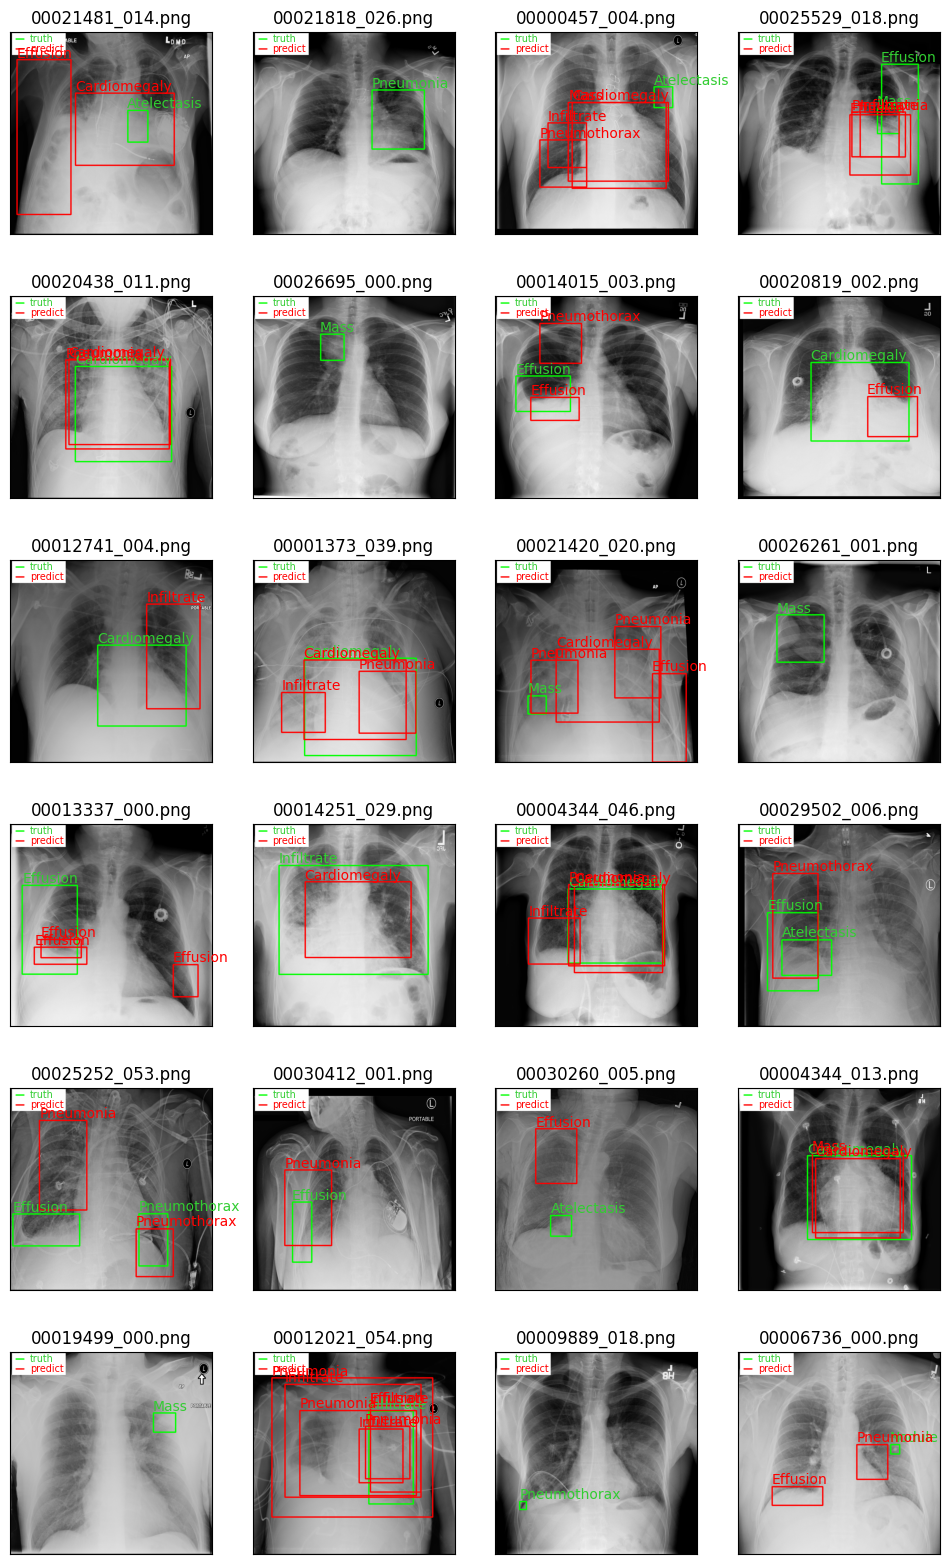

In [22]:
images_show(6, 4)

predict結果を保存

In [23]:
#import shutil
#
#test_div_img = os.path.join(base_path, ver, test_folder, test_img_folder, 'image')
#os.mkdir(test_div_img)

In [24]:
#from PIL import Image, ImageDraw
#
#def save_image(test_results_dict):
#
#    fig = plt.figure()
#    ax = fig.add_subplot(111)
#
#    #元画像の設定
#    img = (test_results_dict['image'][0] * 255).to(torch.uint8)
#    img_ori = np.transpose(img.cpu().numpy(), (1, 2, 0))
#    img_ori = cv2.cvtColor(img_ori, cv2.COLOR_RGB2BGR)
#
#    #正解labelごとにループ
#    for i in range(len(test_results_dict['truth_labels'])):
#
#        #正解bbox,labelの色を指定
#        t_label_index = test_results_dict['truth_labels'][i]
#        t_label_name = label_kind[int(t_label_index)]
#
#        #truth_bboxとtruth_labelを表示
#        cv2.rectangle(img_ori,
#                      (int(test_results_dict['truth_boxes'][i][0]), int(test_results_dict['truth_boxes'][i][1])),
#                      (int(test_results_dict['truth_boxes'][i][2]), int(test_results_dict['truth_boxes'][i][3])),
#                      color=(0, 255, 0),
#                      thickness=5
#                      )
#        ax.text(int(test_results_dict['truth_boxes'][i][0]), int(test_results_dict['truth_boxes'][i][1]-15), t_label_name, color='lime', fontsize='large')
#
#
#    #予測labelごとにループ
#    for i in range(len(test_results_dict['predict_labels'])):
#
#        #予測bbox,labelの色を指定
#        p_label_index = test_results_dict['predict_labels'][i]
#        p_label_name = label_kind[int(p_label_index)]
#
#        #predict_bboxとpredict_labelを表示
#        cv2.rectangle(img_ori,
#                      (int(test_results_dict['predict_boxes'][i][0]), int(test_results_dict['predict_boxes'][i][1])),
#                      (int(test_results_dict['predict_boxes'][i][2]), int(test_results_dict['predict_boxes'][i][3])),
#                      color=(255, 0, 0),
#                      thickness=5
#                      )
#        ax.text(int(test_results_dict['predict_boxes'][i][0]), int(test_results_dict['predict_boxes'][i][1]-15), p_label_name, color='red', fontsize='large')
#
#
#    #凡例の設定
#    cv2.rectangle(img_ori, (10, 10), (250, 120), color=(255, 255, 255), thickness=cv2.FILLED)
#    cv2.line(img_ori, (30, 40), (70, 40), color=(0, 255, 0), thickness=6, lineType=cv2.LINE_8, shift=0)
#    cv2.line(img_ori, (30, 90), (70, 90), color=(255, 0, 0), thickness=6, lineType=cv2.LINE_8, shift=0)
#    ax.text(100, 50, 'truth', color='limegreen')
#    ax.text(100, 100, 'predict', color='red')
#
#
#    #画像の表示
#    title = test_results_dict['file_name'][0]
#    ax.set_title(title)
#    plt.imshow(img_ori)
#    fig.savefig(os.path.join(test_div_img, title))
#    plt.close(fig)
#

In [25]:
#for index in range(len(test_results)):
#    save_image(test_results[index])
#
#shutil.make_archive(os.path.join(test_img_path, 'image'), format='zip', root_dir=test_div_img)
#shutil.rmtree(test_div_img)

全てのweightに対してpredict結果を保存

In [26]:
def save_images(row_num, col_num, images_save_path):

    fig, axes = plt.subplots(nrows=row_num, ncols=col_num, figsize=(12, 60), subplot_kw=({'xticks':(), 'yticks':()}))

    for j, ax in enumerate(axes.flat):
        test_results_dict = test_results[j]

        #元画像の設定
        img = (test_results_dict['image'][0] * 255).to(torch.uint8)
        img_ori = np.transpose(img.cpu().numpy(), (1, 2, 0))
        img_ori = cv2.cvtColor(img_ori, cv2.COLOR_RGB2BGR)

        #正解labelごとにループ
        for i in range(len(test_results_dict['truth_labels'])):

            #正解bbox,labelの色を指定
            t_label_index = test_results_dict['truth_labels'][i]
            t_label_name = label_kind[int(t_label_index)]

            #truth_bboxとtruth_labelを表示
            cv2.rectangle(img_ori,
                          (int(test_results_dict['truth_boxes'][i][0]), int(test_results_dict['truth_boxes'][i][1])),
                          (int(test_results_dict['truth_boxes'][i][2]), int(test_results_dict['truth_boxes'][i][3])),
                          color=(0, 255, 0),
                          thickness=5
                          )
            ax.text(int(test_results_dict['truth_boxes'][i][0]), int(test_results_dict['truth_boxes'][i][1]-15), t_label_name, color='limegreen')

        #予測labelごとにループ
        for i in range(len(test_results_dict['predict_labels'])):

            #予測bbox,labelの色を指定
            p_label_index = test_results_dict['predict_labels'][i]
            p_label_name = label_kind[int(p_label_index)]

            #predict_bboxとpredict_labelを表示
            cv2.rectangle(img_ori,
                          (int(test_results_dict['predict_boxes'][i][0]), int(test_results_dict['predict_boxes'][i][1])),
                          (int(test_results_dict['predict_boxes'][i][2]), int(test_results_dict['predict_boxes'][i][3])),
                          color=(255, 0, 0),
                          thickness=5
                          )
            ax.text(int(test_results_dict['predict_boxes'][i][0]), int(test_results_dict['predict_boxes'][i][1]-15), p_label_name, color='red')

        #凡例の設定
        cv2.rectangle(img_ori, (10, 10), (280, 120), color=(255, 255, 255), thickness=cv2.FILLED)
        cv2.line(img_ori, (30, 40), (70, 40), color=(0, 255, 0), thickness=6, lineType=cv2.LINE_8, shift=0)
        cv2.line(img_ori, (30, 90), (70, 90), color=(255, 0, 0), thickness=6, lineType=cv2.LINE_8, shift=0)
        ax.text(100, 50, 'truth', color='limegreen', fontsize='x-small')
        ax.text(100, 100, 'predict', color='red', fontsize='x-small')

        #画像の表示
        ax.set_title(test_results_dict['file_name'][0])
        ax.imshow(img_ori)
    fig.savefig(images_save_path, dpi=500)
    plt.close(fig)


In [ ]:
import random
import shutil
from PIL import Image, ImageDraw

all_images_dir = os.path.join(test_img_path, 'all_images')
os.mkdir(all_images_dir)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

weight_dirs = glob(os.path.join(weight_folder_path, 'weight_*'))

for weight_dir in weight_dirs:

    weight_name = os.path.splitext(os.path.basename(weight_dir))[0]

    model.load_state_dict(torch.load(weight_dir))

    test_results = []

    model.eval()
    with torch.no_grad():

        for batch in test_loader:
            image, target, name = batch

            image = image.to(device)

            predictions = model(image)

            #print(predictions)
            image = image.cpu()
            truth_boxes = target['boxes'][0].cpu()
            truth_labels = target['labels'][0].cpu()

            predict_boxes = predictions[0]["boxes"].cpu()
            predict_labels = predictions[0]["labels"].cpu()
            predict_scores = predictions[0]["scores"].cpu()


            dict_info = {'image':image, 'truth_boxes':truth_boxes, 'truth_labels':truth_labels, 'file_name':name,
                         'predict_boxes':predict_boxes, 'predict_labels':predict_labels, 'scores':predict_scores}

            test_results.append(dict_info)

    images_save_path = os.path.join(all_images_dir, f'images_{weight_name}.png')

    save_images(18, 4, images_save_path)